In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
import re
from collections import Counter
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.utils.data as data
from torchvision import datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [28]:
train_feature_75ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_128wz_75ol.npy')
train_label_75ol = np.load('../Data/UTDMHAD_data/UTD_train_label_128wz_75ol.npy')
test_feature_75ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_128wz_75ol.npy')
test_label_75ol = np.load('../Data/UTDMHAD_data/UTD_test_label_128wz_75ol.npy')

train_feature_50ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_128wz_50ol.npy')
train_label_50ol = np.load('../Data/UTDMHAD_data/UTD_train_label_128wz_50ol.npy')
test_feature_50ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_128wz_50ol.npy')
test_label_50ol = np.load('../Data/UTDMHAD_data/UTD_test_label_128wz_50ol.npy')

train_feature_25ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_128wz_25ol.npy')
train_label_25ol = np.load('../Data/UTDMHAD_data/UTD_train_label_128wz_25ol.npy')
test_feature_25ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_128wz_25ol.npy')
test_label_25ol = np.load('../Data/UTDMHAD_data/UTD_test_label_128wz_25ol.npy')

train_feature_0ol = np.load('../Data/UTDMHAD_data/UTD_train_feature_128wz_0ol.npy')
train_label_0ol = np.load('../Data/UTDMHAD_data/UTD_train_label_128wz_0ol.npy')
test_feature_0ol = np.load('../Data/UTDMHAD_data/UTD_test_feature_128wz_0ol.npy')
test_label_0ol = np.load('../Data/UTDMHAD_data/UTD_test_label_128wz_0ol.npy')

# 128 window_size %75 overlapping

In [78]:
train_dataset_75ol = TensorDataset(torch.from_numpy(train_feature_75ol).to(torch.float32),torch.from_numpy(train_label_75ol).to(torch.float32))

test_dataset_75ol = TensorDataset(torch.from_numpy(test_feature_75ol).to(torch.float32),torch.from_numpy(test_label_75ol).to(torch.float32))


In [79]:
train_loader_75ol = data.DataLoader(dataset = train_dataset_75ol, batch_size = 32, shuffle = True)

test_loader_75ol = data.DataLoader(dataset = test_dataset_75ol, batch_size = 32, shuffle = False)

In [80]:
class CNN_UTD(nn.Module):
    def __init__(self):
        super(CNN_UTD, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(6336, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_75 = CNN_UTD().to(device)

In [81]:
epoches = 10
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_75.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [82]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_75ol:
        imgs = imgs.reshape(len(imgs),1,32,24)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_75(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  29.923574368018812  % Loss:  2.3841925647771247
Epoch:  2 accuracy:  57.58377425044092  % Loss:  1.351989516588015
Epoch:  3 accuracy:  66.10817166372722  % Loss:  1.0166686060272645
Epoch:  4 accuracy:  74.54438565549677  % Loss:  0.7697497350033199
Epoch:  5 accuracy:  79.07113462669018  % Loss:  0.6166195409877278
Epoch:  6 accuracy:  85.33215755437978  % Loss:  0.4419640682846586
Epoch:  7 accuracy:  87.88947677836566  % Loss:  0.3486134247662865
Epoch:  8 accuracy:  91.21105232216344  % Loss:  0.2765000829490546
Epoch:  9 accuracy:  92.26925338036449  % Loss:  0.23898712785862317
Epoch:  10 accuracy:  94.88536155202821  % Loss:  0.167542581246278


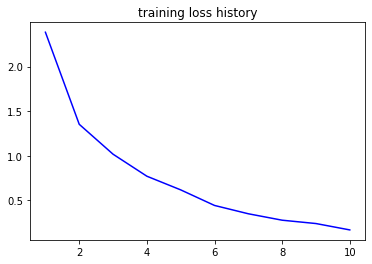

In [84]:
import matplotlib.pyplot as plt
x = []
for i in range(1,11):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [85]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_75ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,24)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_75(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  72.15363511659808


# 128 window_size %50 overlapping

In [31]:
train_dataset_50ol = TensorDataset(torch.from_numpy(train_feature_50ol).to(torch.float32),torch.from_numpy(train_label_50ol).to(torch.float32))

test_dataset_50ol = TensorDataset(torch.from_numpy(test_feature_50ol).to(torch.float32),torch.from_numpy(test_label_50ol).to(torch.float32))

train_loader_50ol = data.DataLoader(dataset = train_dataset_50ol, batch_size = 32, shuffle = True)

test_loader_50ol = data.DataLoader(dataset = test_dataset_50ol, batch_size = 32, shuffle = False)


In [36]:
class CNN_UTD_50(nn.Module):
    def __init__(self):
        super(CNN_UTD_50, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(6336, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_50 = CNN_UTD_50().to(device)
epoches = 10
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_50.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [37]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_50ol:
        imgs = imgs.reshape(len(imgs),1,32,24)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_50(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  17.225161669606113  % Loss:  2.832912113931444
Epoch:  2 accuracy:  45.03233392122281  % Loss:  1.825664378978588
Epoch:  3 accuracy:  57.084068195179306  % Loss:  1.402979205052058
Epoch:  4 accuracy:  67.90123456790124  % Loss:  1.0121866464614868
Epoch:  5 accuracy:  72.78071722516167  % Loss:  0.8471889716607554
Epoch:  6 accuracy:  79.24750146972369  % Loss:  0.6439593853773894
Epoch:  7 accuracy:  84.891240446796  % Loss:  0.45410343673494125
Epoch:  8 accuracy:  90.47619047619048  % Loss:  0.3139811412051872
Epoch:  9 accuracy:  93.06290417401529  % Loss:  0.2263175276004606
Epoch:  10 accuracy:  96.00235155790712  % Loss:  0.17255828840037188


In [30]:
train_label_50ol

array([25.,  6.,  7., ..., 12., 15., 13.])

In [38]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_50ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,24)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_50(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  60.768175582990395


# 128 window_size %25 overlapping

In [39]:
train_dataset_25ol = TensorDataset(torch.from_numpy(train_feature_25ol).to(torch.float32),torch.from_numpy(train_label_25ol).to(torch.float32))

test_dataset_25ol = TensorDataset(torch.from_numpy(test_feature_25ol).to(torch.float32),torch.from_numpy(test_label_25ol).to(torch.float32))

train_loader_25ol = data.DataLoader(dataset = train_dataset_25ol, batch_size = 32, shuffle = True)

test_loader_25ol = data.DataLoader(dataset = test_dataset_25ol, batch_size = 32, shuffle = False)


In [40]:
class CNN_UTD_25(nn.Module):
    def __init__(self):
        super(CNN_UTD_25, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(6336, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_25 = CNN_UTD_25().to(device)
epoches = 10
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_25.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [41]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_25ol:
        imgs = imgs.reshape(len(imgs),1,32,24)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_25(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  12.610229276895943  % Loss:  2.9839517143037586
Epoch:  2 accuracy:  38.80070546737213  % Loss:  2.0872070822450848
Epoch:  3 accuracy:  52.29276895943563  % Loss:  1.5669708417521582
Epoch:  4 accuracy:  63.492063492063494  % Loss:  1.138781453172366
Epoch:  5 accuracy:  71.42857142857143  % Loss:  0.9095828466945224
Epoch:  6 accuracy:  78.65961199294533  % Loss:  0.6887894695003828
Epoch:  7 accuracy:  82.45149911816578  % Loss:  0.5513019495540195
Epoch:  8 accuracy:  86.86067019400353  % Loss:  0.4286456128789319
Epoch:  9 accuracy:  91.71075837742504  % Loss:  0.30844709194368786
Epoch:  10 accuracy:  94.79717813051147  % Loss:  0.19016841550668082


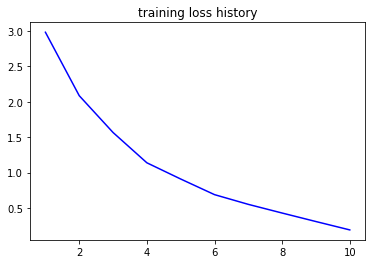

In [43]:
import matplotlib.pyplot as plt
x = []
for i in range(1,11):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [42]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_25ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,24)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_25(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  61.31687242798354


# 128 window_size %0 overlapping

In [44]:
train_dataset_0ol = TensorDataset(torch.from_numpy(train_feature_0ol).to(torch.float32),torch.from_numpy(train_label_0ol).to(torch.float32))

test_dataset_0ol = TensorDataset(torch.from_numpy(test_feature_0ol).to(torch.float32),torch.from_numpy(test_label_0ol).to(torch.float32))

train_loader_0ol = data.DataLoader(dataset = train_dataset_0ol, batch_size = 32, shuffle = True)

test_loader_0ol = data.DataLoader(dataset = test_dataset_0ol, batch_size = 32, shuffle = False)


In [46]:
class CNN_UTD_0(nn.Module):
    def __init__(self):
        super(CNN_UTD_0, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
                nn.ReLU()
        )
        self.fc1 = nn.Linear(6336, 512)
        self.fc3 = nn.Linear(512,27)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)           
        out = self.fc3(out)
        return out
        
model_0 = CNN_UTD_0().to(device)
epoches = 10
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_0.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [47]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_0ol:
        imgs = imgs.reshape(len(imgs),1,32,24)
#         imgs = imgs.reshape(len(imgs),1,16,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_0(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  9.647058823529411  % Loss:  3.0826052824656167
Epoch:  2 accuracy:  32.705882352941174  % Loss:  2.2842001385158963
Epoch:  3 accuracy:  46.705882352941174  % Loss:  1.8179191969059132
Epoch:  4 accuracy:  59.529411764705884  % Loss:  1.3313521610365973
Epoch:  5 accuracy:  70.11764705882354  % Loss:  0.989971986523381
Epoch:  6 accuracy:  76.94117647058823  % Loss:  0.8030354822123492
Epoch:  7 accuracy:  77.17647058823529  % Loss:  0.7278746885282023
Epoch:  8 accuracy:  84.94117647058823  % Loss:  0.524780132152416
Epoch:  9 accuracy:  89.88235294117646  % Loss:  0.3535311271746953
Epoch:  10 accuracy:  93.6470588235294  % Loss:  0.24984593606657451


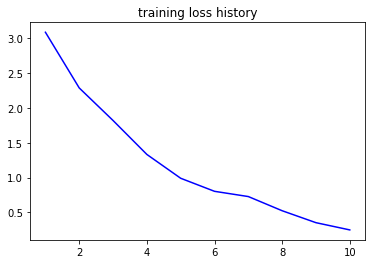

In [48]:
import matplotlib.pyplot as plt
x = []
for i in range(1,11):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [49]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_0ol:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,24)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_0(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('validation accuracy is: ',test_accuracy)

validation accuracy is:  53.6986301369863
